In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import copy # 조기종료를 위해 깊은 복사를 사용을 위해
import matplotlib.pyplot as plt


# PyTorch 출력 형식 조정
torch.set_printoptions(precision=8, threshold=10000, edgeitems=3)

In [35]:
train_data = "C:/Users/admin/Downloads/wiset_single_sensor_model_train_data_3.xlsx"
test_data = "C:/Users/admin/Downloads/test_data_20240407.xlsx"

# 엑셀데이터 데이터프레임으로 읽어오기
trains_df = pd.read_excel(train_data)
tests_df = pd.read_excel(test_data)

# train 데이터프레임의 모든 object 타입 열을 숫자로 변환
for col in trains_df.select_dtypes(include=['object']).columns:
    trains_df[col] = pd.to_numeric(trains_df[col], errors='coerce')
    
# test 데이터프레임의 모든 object 타입 열을 숫자로 변환
for col in tests_df.select_dtypes(include=['object']).columns:
    tests_df[col] = pd.to_numeric(tests_df[col], errors='coerce')

In [37]:
# 불필요한 열 제거
trains = trains_df.drop(columns=['Unnamed: 0', 'datetime'])
tests = tests_df.drop(columns=['datetime'])

In [81]:
# input과 target 데이터 나누기 - train
train_input = trains.drop(columns=['illum'], axis=1).to_numpy()
train_target = trains['illum'].to_numpy()

# test
test_input = tests.drop(columns=['illum'], axis=1).to_numpy()
test_target = tests['illum'].to_numpy()

# 데이터 정규화
#mean = train_input.mean(axis=0)
#std = train_input.std(axis=0)
#train_input = (train_input - mean) / std
#test_input = (test_input - mean) / std

# 데이터셋에서 NaN 값이나 Inf 값이 있는지 확인
print(np.isnan(train_input).sum(), np.isnan(train_target).sum())
print(np.isinf(train_input).sum(), np.isinf(train_target).sum())
print(np.isnan(test_input).sum(), np.isnan(test_target).sum())
print(np.isinf(test_input).sum(), np.isinf(test_target).sum())

# 데이터가 제대로 로드되었는지 확인
print(train_input[:5])
print(train_target[:5])
print(test_input[:5])
print(test_target[:5])

# Numpy 배열의 데이터 타입 변환
train_input = train_input.astype(np.float32)
train_target = train_target.astype(np.float32)
test_input = test_input.astype(np.float32)
test_target = test_target.astype(np.float32)

# 파이토치 모델 쓰려면 df or numpy -> Pytorch 텐서로 변환해야 됨
train_input = torch.tensor(train_input, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

0 0
0 0
0 0
0 0
[[   1.58         86.62         20.29812331 -120.            0.
    10.        ]
 [   1.76         86.77         21.88431069 -120.            0.
    10.        ]
 [   1.95         86.92         23.59229004 -120.            0.
    10.        ]
 [   2.13         87.07         25.2856471  -120.            0.
    10.        ]
 [   2.32         87.22         27.09501511 -120.            0.
    10.        ]]
[14.79543042 15.90832831 17.07782089 18.4506     19.7667059 ]
[[   1.58         82.31         23.97280136 -120.            0.
    10.        ]
 [   1.76         82.46         26.07702085 -120.            0.
    10.        ]
 [   1.95         82.61         28.23505227 -120.            0.
    10.        ]
 [   2.13         82.76         30.23214008 -120.            0.
    10.        ]
 [   2.32         82.91         32.20696157 -120.            0.
    10.        ]]
[17.62096515 19.0322753  20.4899621  21.86490514 23.23443218]


In [83]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_input, train_target = train_input.to(device), train_target.to(device)
test_input, test_target = test_input.to(device), test_target.to(device)


In [85]:
# 데이터셋과 데이터로더 생성(미니배치)
# epoch 너무 느릴 때 데이터를 배치로 나눠 처리하게 하기

# 배치 크기 늘리면 에포크 학습시간 단축됨
# 너무 크면 메모리 사용량 증가시킴
train_dataset = TensorDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

In [87]:
# dnn 모델
class dnn(nn.Module):
    # 생성자에서 모델의 구조 정의
    def __init__(self):
        # nn.Module 클래스를 상속받아 super로 nn.Module의 초기화 메소드 호출
        super(dnn, self).__init__()
        # 입력층(은닉층1) 입력 6개 - elevation, azimuth, new_illum_11, x, y, point
        self.fc1 = nn.Linear(6, 2048)
        
        # droopout 과대적합 방지 - 학습 중에만 활성화(평가, 예측 시 비활성화)
        # 은닉층 뒤에 추가됨
        #self.dropout1 = nn.Dropout(0.5) 
        
        # 64개의 출력 뉴런에 대해 배치 정규화
        # 각 층에 입력되는 데이터의 분포를 정규화하여 학습 안정화, 속도 높임
        # 각 층 뒤, 활성함수 이전에 사용
        self.bn1 = nn.BatchNorm1d(2048)
    
        # 은닉층과 배치 정규화
        self.fc2 = nn.Linear(2048, 4092)
        self.bn2 = nn.BatchNorm1d(4092)
        
        self.fc3 = nn.Linear(4092, 2048)
        self.bn3 = nn.BatchNorm1d(2048)

        # 출력층 출력 1개
        self.fc4 = nn.Linear(2048, 1)
        self.dropout = nn.Dropout(0.2)
        
        # forward: 각 계층 연결방식, 활성화 함수, 추가 처리 적용
        # fc1 선형계층 -> bn1 배치활성화 -> relu로 비선형성 적용
    def forward(self, x):
        # 활성화 함수 relu 사용 (비교되는거 - 시그모이드)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
            
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
            
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        x = self.fc4(x) # 출력층
            
        return x

In [89]:
# 모델 생성
input_size = train_input.shape[1]
print(train_input)
model = dnn()
model.to(device)

tensor([[   1.58000004,   86.62000275,   20.29812241, -120.00000000,
            0.00000000,   10.00000000],
        [   1.75999999,   86.76999664,   21.88430977, -120.00000000,
            0.00000000,   10.00000000],
        [   1.95000005,   86.91999817,   23.59229088, -120.00000000,
            0.00000000,   10.00000000],
        ...,
        [   1.63999999,  295.85000610,    1.43466926,  120.00000000,
          180.00000000,    9.00000000],
        [   1.48000002,  296.00000000,    1.35967779,  120.00000000,
          180.00000000,    9.00000000],
        [   1.30999994,  296.14001465,    1.27099180,  120.00000000,
          180.00000000,    9.00000000]], device='cuda:0')


dnn(
  (fc1): Linear(in_features=6, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=4092, bias=True)
  (bn2): BatchNorm1d(4092, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4092, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [91]:
# 가중치 초기화 함수 적용
# 각 리니어 레이어의 가중치를 He 방식으로 초기화
# 균형 잡힌 학습을 도와줌
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

model.apply(initialize_weights)

dnn(
  (fc1): Linear(in_features=6, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=4092, bias=True)
  (bn2): BatchNorm1d(4092, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4092, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [93]:
# 손실함수, 옵티마이저
criterion = nn.L1Loss() # MAE 손실함수
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [95]:
# 예시 배치 데이터
batch_inputs, batch_targets = next(iter(train_loader))
batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

# 모델 예측
model.eval()
with torch.no_grad():
    outputs = model(batch_inputs)

# 출력 크기와 타깃 크기 확인
print(f'Outputs shape: {outputs.shape}')
print(f'Batch targets shape: {batch_targets.shape}')


Outputs shape: torch.Size([256, 1])
Batch targets shape: torch.Size([256])


In [96]:
# 학습률 감소 스케줄러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

In [97]:
# 조기 종료 설정
patience = 50  # 성능 향상이 없을 때 기다릴 에포크 수
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

In [98]:
# 손실 값을 저장할 리스트 초기화
train_losses = []
test_losses = []

In [103]:
# train_target과 test_target을 하나의 텐서로 합치기
all_targets = torch.cat((train_target, test_target))

# 타겟 값의 평균 계산
target_mean = torch.mean(all_targets).item()
print(f"Target Mean: {target_mean}")

# 허용 가능한 상대적 오차 설정
acceptable_relative_error = 0.05  # 5%

# 최적의 손실 값 범위 계산
optimal_loss_upper_bound = target_mean * acceptable_relative_error
print(f"Optimal Loss Upper Bound: {optimal_loss_upper_bound}")

Target Mean: 237.4127960205078
Optimal Loss Upper Bound: 11.87063980102539


In [105]:
# 모델 학습
epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch_inputs, batch_targets in train_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)  # 배치 데이터를 GPU로 이동
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets.unsqueeze(1))  # MAE 손실 계산
        loss.backward()
        optimizer.step()
    
    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_input)
        test_loss = criterion(test_outputs, test_target.unsqueeze(1))

    # 손실 값 저장
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    scheduler.step(test_loss)

    # 과대적합: 훈련 손실 < 검증 손실 - 드롭아웃 비율 증가, 층 적게, 규제 크게, 
    # 과소적합: 훈련 손실, 검증 손실 모두 높고 반대
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1/1000], Loss: 19.6586, Test Loss: 14.6170
Epoch [11/1000], Loss: 12.0265, Test Loss: 13.1365
Epoch [21/1000], Loss: 12.0225, Test Loss: 10.8483
Epoch [31/1000], Loss: 10.7257, Test Loss: 12.3592
Epoch [41/1000], Loss: 20.1104, Test Loss: 9.6435
Epoch [51/1000], Loss: 12.8132, Test Loss: 12.9085
Epoch [61/1000], Loss: 10.8069, Test Loss: 12.8602
Epoch [71/1000], Loss: 12.7128, Test Loss: 10.0756
Early stopping at epoch 78


In [106]:
# 가장 성능이 좋은 모델 가중치 로드
model.load_state_dict(best_model_wts)

<All keys matched successfully>

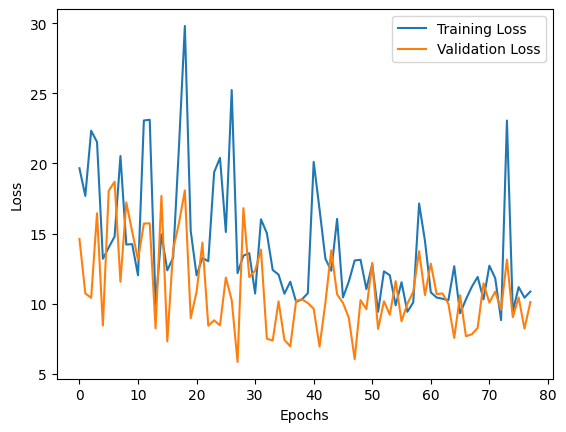

In [107]:
# 손실 값 그래프 그리기
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
# 학습된 모델을 평가 모드로 전환 (추론을 위해)
model.eval()

dnn(
  (fc1): Linear(in_features=6, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=4092, bias=True)
  (bn2): BatchNorm1d(4092, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4092, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [109]:
# 테스트 데이터에 대한 예측 및 MAE 계산
with torch.no_grad():
    test_outputs = model(test_input)
    test_loss = criterion(test_outputs, test_target.unsqueeze(1))
    predictions = model(test_input.to(device)).cpu().numpy()

    print(f'Test MAE: {test_loss.item():.4f}')

Test MAE: 5.8494


In [110]:
# 테스트 데이터에 예측값 추가
tests_df['Predicted_illum'] = predictions

# 예측 결과를 엑셀 파일로 저장
tests_df.to_excel("wiset_dnn3.xlsx", index=False)
print("wiset_dnn3.xlsx")

wiset_dnn3.xlsx
